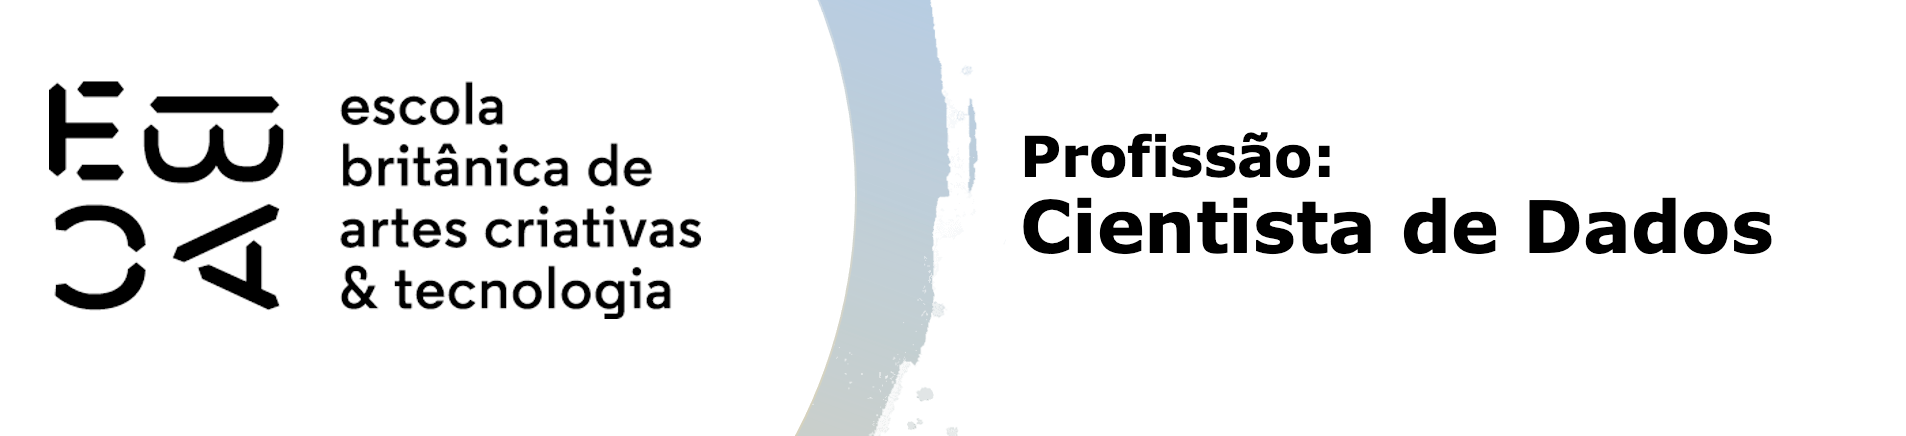

# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import pandas as pd
import numpy as np

from pycaret.classification import *
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

In [2]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


### Amostragem, descritiva básica univariada e bivariada, desenvolvimento e avaliação do modelo



<div style="background-color: #faf2d7; padding: 15px 7px 15px 7px;">

A análise da amostragem dos dados, a análise descritiva univariada e bivariada, o desenvolvimento do modelo com tratamento de dados assim como sua avaliação se encontram em um Notebook separado que pode ser visualizado pelo link abaixo:
    
https://github.com/oelderid/ebac/blob/master/M%C3%B3dulo%2037%20-%20Regress%C3%A3o%20Log%C3%ADstica%20II/ProfCientistaDados_m37_supportmaterial_exercise02_v02.ipynb
    
</div>

# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

<div style="background-color: #eafce3; padding: 15px 7px 15px 7px;">

Como já foi observado em exercícios anteriores que utilizaram a mesma base de dados, existem dados nulos na base especificamente para o tipo de renda Pensionista. Esses não possui tempo de emprego definido, como pode ser comprovado abaixo:
    
</div>

In [3]:
df[df.tempo_emprego.isna()]['tipo_renda'].unique()[0]

'Pensionista'

<div style="background-color: #eafce3; padding: 15px 7px 15px 7px;">

Os valores faltantes serão preenchidos com a média do tempo de emprego.
    
</div>

In [4]:
def imput_mean(data: pd.DataFrame):
    mean = data['tempo_emprego'].mean()
    data.loc[df.tempo_emprego.isna(), 'tempo_emprego'] = mean
    return data

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

<div style="background-color: #eafce3; padding: 15px 7px 15px 7px;">

Como já foi observado em exercícios anteriores que utilizaram a mesma base de dados, serão removidos os registros com 5 filhos ou mais, todos os registros de Bolsistas e uma união entre algumas categorias do estado civil e educação.
    
</div>

In [5]:
def outliers(data: pd.DataFrame):
    data.drop(data.query('qtd_filhos >= 5').index, inplace=True)
    data.drop(data.query('tipo_renda == "Bolsista"').index, inplace=True)
    data['estado_civil'].replace({'Separado': 'Solteiro', 'União': 'Casado'}, inplace=True)
    data['educacao'].replace({'Superior incompleto': 'Superior','Superior completo': 'Superior'}, inplace=True)
    data['educacao'].replace({'Pós graduação': 'Superior'}, inplace=True)
    return data

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

<div style="background-color: #eafce3; padding: 15px 7px 15px 7px;">

Será utilizada a técnica de Feature importance através do RandomForestClassifier, selecionando inicialmente as 20 variáveis com maior importância.
    
</div>

In [6]:
def feature(data: pd.DataFrame):
    X = data.copy()
    y = X['mau']
    X.drop(columns=['mau', 'data_ref', 'index'], inplace=True, errors='ignore')
    
    forest = RandomForestClassifier(random_state=0, n_jobs=-1)
    forest.fit(X, y)
    
    importances = forest.feature_importances_
    forest_importances = pd.Series(importances, index=list(X.columns))
    
    remove = list(forest_importances.sort_values(ascending=False)[20:].index)
    X.drop(columns=remove, inplace=True, errors='ignore')
    return X

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [7]:
def fpca(data: pd.DataFrame):
    X_train = data
    train_features = X_train

    # criando o PCA
    model = PCA(n_components=5).fit(train_features)
    X_pc = model.transform(train_features)

    # número de componentes
    n_pcs= model.components_.shape[0]

    # obtenha o índice do recurso mais importante em CADA componente, ou seja, o maior valor absoluto
    most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

    initial_feature_names = X_train.columns.tolist()

    # recuperando os nomes
    most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

    # removendo as colunas não selecionadas
    remove = [item for item in list(data.columns) if item not in most_important_names]
    data.drop(columns=remove, inplace=True, errors='ignore')
    return data

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [8]:
def dummies(data: pd.DataFrame):
    data['renda'] = np.log(data['renda'])
    return pd.get_dummies(data, drop_first=True)

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [9]:
preprocessamento = make_pipeline(
    FunctionTransformer(imput_mean),
    FunctionTransformer(outliers),
    FunctionTransformer(dummies),
    FunctionTransformer(feature),
    FunctionTransformer(fpca)
)

In [10]:
base = preprocessamento.transform(df)

In [11]:
base.head()

,idade,tempo_emprego,qt_pessoas_residencia,renda,educacao_Médio
0,43,6.873973,1.0,7.830183,1
1,35,4.526027,2.0,8.064696,1
2,31,0.243836,4.0,7.366628,1
3,54,12.772603,2.0,9.526695,1
4,31,8.432877,1.0,7.969385,0


# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [3]:
df.drop(columns=['data_ref', 'index'], inplace=True, errors='ignore')

# aqui os dados serão limitados em 40 mil registros por limitações de processamento e memória
dataset = df.sample(40000)

data = dataset.sample(frac=0.95, random_state=786)
data_unseen = dataset.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
data.qtd_filhos = data.qtd_filhos.astype(float)
data.idade = data.idade.astype(float)

In [6]:
# fazendo o setup do pycaret

datasetup = setup(
    data = data, 
    target = 'mau', 
    session_id = 123,
    experiment_name='Mod38Exercicio1',
    normalize=True, 
    normalize_method='zscore',
    transformation=True, 
    transformation_method = 'quantile',
    fix_imbalance=True,
    pca=True,
    pca_method='incremental',
    pca_components=7,
    feature_selection=True,
    feature_selection_method='classic',
)

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(38000, 13)"
4,Transformed data shape,"(60402, 3)"
5,Transformed train set shape,"(49002, 3)"
6,Transformed test set shape,"(11400, 3)"
7,Numeric features,5
8,Categorical features,7
9,Rows with missing values,17.0%


In [7]:
# construindo o modelo lightgbm com 4 folds

lgbm = create_model('lightgbm', fold=4)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7099,0.0000,0.3263,0.0979,0.1506,0.0334,0.0423
1,0.7472,0.0000,0.3390,0.1177,0.1748,0.0652,0.0780
2,0.7421,0.0000,0.3048,0.1060,0.1572,0.0454,0.0543
3,0.7477,0.0000,0.3352,0.1169,0.1734,0.0638,0.0762
Mean,0.7367,0.0000,0.3263,0.1096,0.1640,0.0520,0.0627
Std,0.0156,0.0000,0.0133,0.0082,0.0104,0.0133,0.0150


### Gráfico AUC

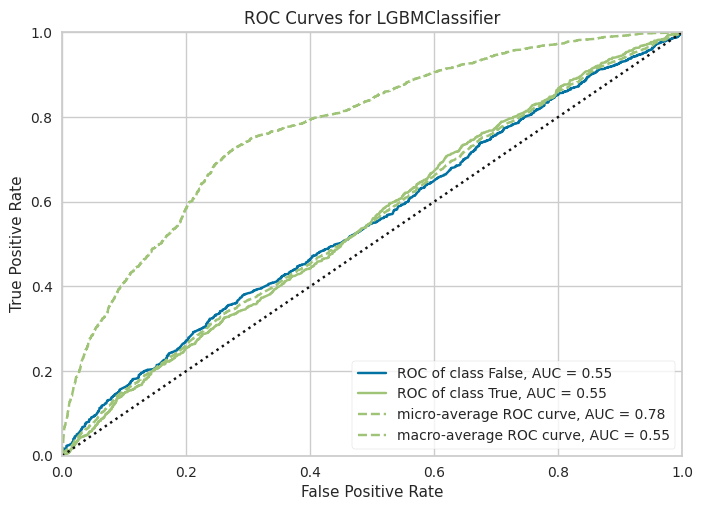

In [9]:
plot_model(lgbm, plot='auc')

### Gráfico Precision-Recall

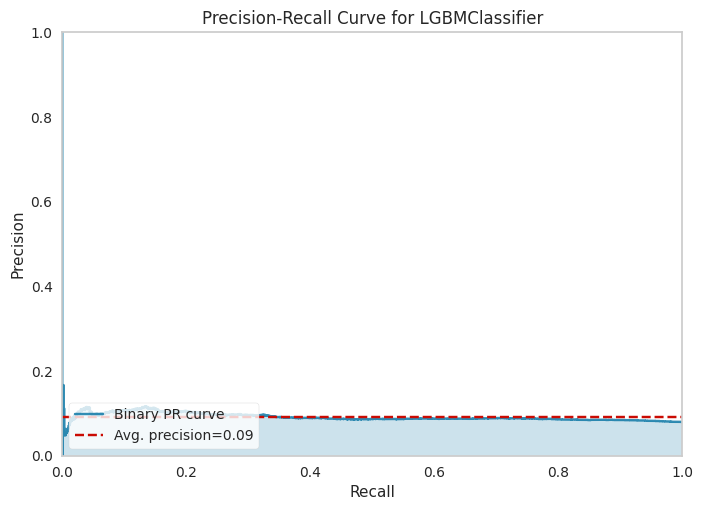

In [10]:
plot_model(lgbm, plot='pr')

### Gráfico Matriz de confusão

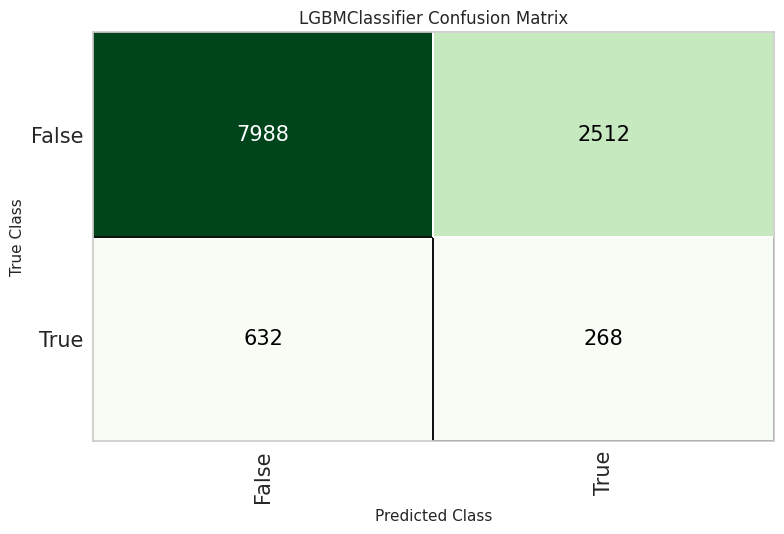

In [11]:
plot_model(lgbm, plot='confusion_matrix')

### Salvando o pipeline e o modelo

In [13]:
save_model(lgbm, 'modelo_exercicio');

Transformation Pipeline and Model Successfully Saved
